### Onset detection
Notebook prepared by Sonia Rodriguez Luque to demonstrate onset detection from novelty functions: spectral flux and high frequency content

In [1]:
#Downloading samples from ODB database: 
#https://grfia.dlsi.ua.es/cm/worklines/pertusa/onset/ODB/
import urllib.request
import os, sys

targetDir='../../data/onset/'
if not os.path.exists(targetDir):
    os.mkdir(targetDir)

waveDir='https://grfia.dlsi.ua.es/cm/worklines/pertusa/onset/ODB/sounds/'
annotationDir='https://grfia.dlsi.ua.es/cm/worklines/pertusa/onset/ODB/ground-truth/'
wavFileNames=['25-rujero.wav','RM-C036.wav']

for file in wavFileNames:
    #Downlaoding wave and annotation files
    urllib.request.urlretrieve(waveDir+file,file)
    annotFile=file.replace('.wav','.txt')
    urllib.request.urlretrieve(annotationDir+annotFile,annotFile)
    #moving files to '../data/onset/'
    os.rename(file,targetDir+file)
    os.rename(annotFile,targetDir+annotFile)

print('Data downloaded in: ',targetDir)

Data downloaded in:  ../../data/onset/


In [2]:
#Imports and initializations
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from essentia.standard import *
import scipy
import math
from scipy.signal import medfilt,argrelextrema
import os
fs=44100
durInSecs=5
t=np.arange(durInSecs*fs)/float(fs)
windowSize=2048
hopSize=512

In [3]:
#Novelty function computation function definitions
def spectralFlux(x,windowSize,hopSize,winType="hann"):
    w = Windowing(type = winType)
    spectrum = Spectrum(size = windowSize)
    SF=[];SPEC=[]
    
    for frame in FrameGenerator(x, frameSize = windowSize, hopSize = hopSize):
        ampSpec = spectrum(w(frame))
        SPEC.append(ampSpec)
    
    for i in range (1,len(SPEC)):
        SF_aux=(SPEC[i]-SPEC[i-1])**2
        SF_sum=math.sqrt(sum(SF_aux))
        SF.append(SF_sum)  
    
    return SF

def highFreqCont(x,windowSize,hopSize,winType="hann"):
    w = Windowing(type = winType)
    spectrum = Spectrum(size = windowSize)

    hfc=[]
    for frame in FrameGenerator(x, frameSize = windowSize, hopSize = hopSize):
        ampSpec = spectrum(w(frame))
        hfc.append(np.dot(np.power(ampSpec,2),np.arange(ampSpec.size)))
    hfc=np.array(hfc)
    return hfc

A robust peak-picking algorithm is needed to estimate the onset times of events within the analysis signal. We will divide the process of onset detection from a novelty function in three steps: post-processing, thresholding, and a final decision process.

In [4]:
def onsetDetection(noveltyFunction, lpfCut):   
    # Post-Processing
    
    '''
    Smoothing and normalization of the novelty function: The purpose of 
    post-processing is to facilitate the tasks of thresholding and 
    peak-picking by increasing the uniformity and consistency of 
    event-related features in the detection function, ideally transforming 
    them into isolated, easily detectable local maxima
    '''
    # Normalizing subtracting the mean and dividing by the maximum absolute deviation
    novelty_norm= (noveltyFunction-np.mean(noveltyFunction))/np.max(abs(noveltyFunction-np.mean(noveltyFunction)))
    #novelty_norm=noveltyFunction
    
    # Smoothing: Low pass filter
    lpf=LowPass(cutoffFrequency=lpfCut)
    novelty_lpf=lpf(essentia.array(novelty_norm))
    
    # Thresholding
    '''
    It is necessary to define a threshold which effectively separates
    event-related and nonevent-related peaks. There are two main approaches
    to defining this threshold: fixed thresholding and adaptive thresholding.
    Fixed thresholding methods define onsets as peaks, where the detection
    function has its local maximas
    '''
    thr_func=novelty_norm-novelty_lpf
    thr_func=thr_func+np.abs(thr_func)

    # Peak-Picking
    '''
    So, peak picking is reduced to identify peaks in the thresholding function. 
    Fixed thresholding methods define onsets as peaks, where the detection
    function has its local maxima.
    '''
    onsets_sec=np.asarray(argrelextrema(thr_func,np.greater))
    onsets_thr=np.asarray(argrelextrema(thr_func,np.greater,order=5)) #order: How many points on each side to use for the comparison to consider comparator(n, n+x) to be True.

    return onsets_sec, thr_func, novelty_lpf, onsets_thr

In [5]:
targetDir='../../data/onset/'
# to show differences between percussive and non-percussive detections in class
file='25-rujero.wav' 
file_perc='RM-C036.wav'

fileName = os.path.join(targetDir,file)
x = MonoLoader(filename = fileName, sampleRate = fs)()
x = x[:durInSecs*fs]#let's use only the first five seconds of the signals
x = x/np.max(np.abs(x))

# Computing the novely function
SF=spectralFlux(x,windowSize,hopSize);SF=SF/np.max(SF)
hfc=highFreqCont(x,windowSize,hopSize);hfc=hfc/np.max(hfc)

# Computing the onset detection
[onsets_hfc, thr,nov,onsets_thr_hfc] = onsetDetection(hfc,1500)
[onsets_SF, thr_SF,nov_SF,onsets_thr_SF] = onsetDetection(SF,500)

#reading ground-truth annotation
onsets=np.loadtxt(fileName.replace('.wav','.txt'))
onsets=onsets[onsets<durInSecs]

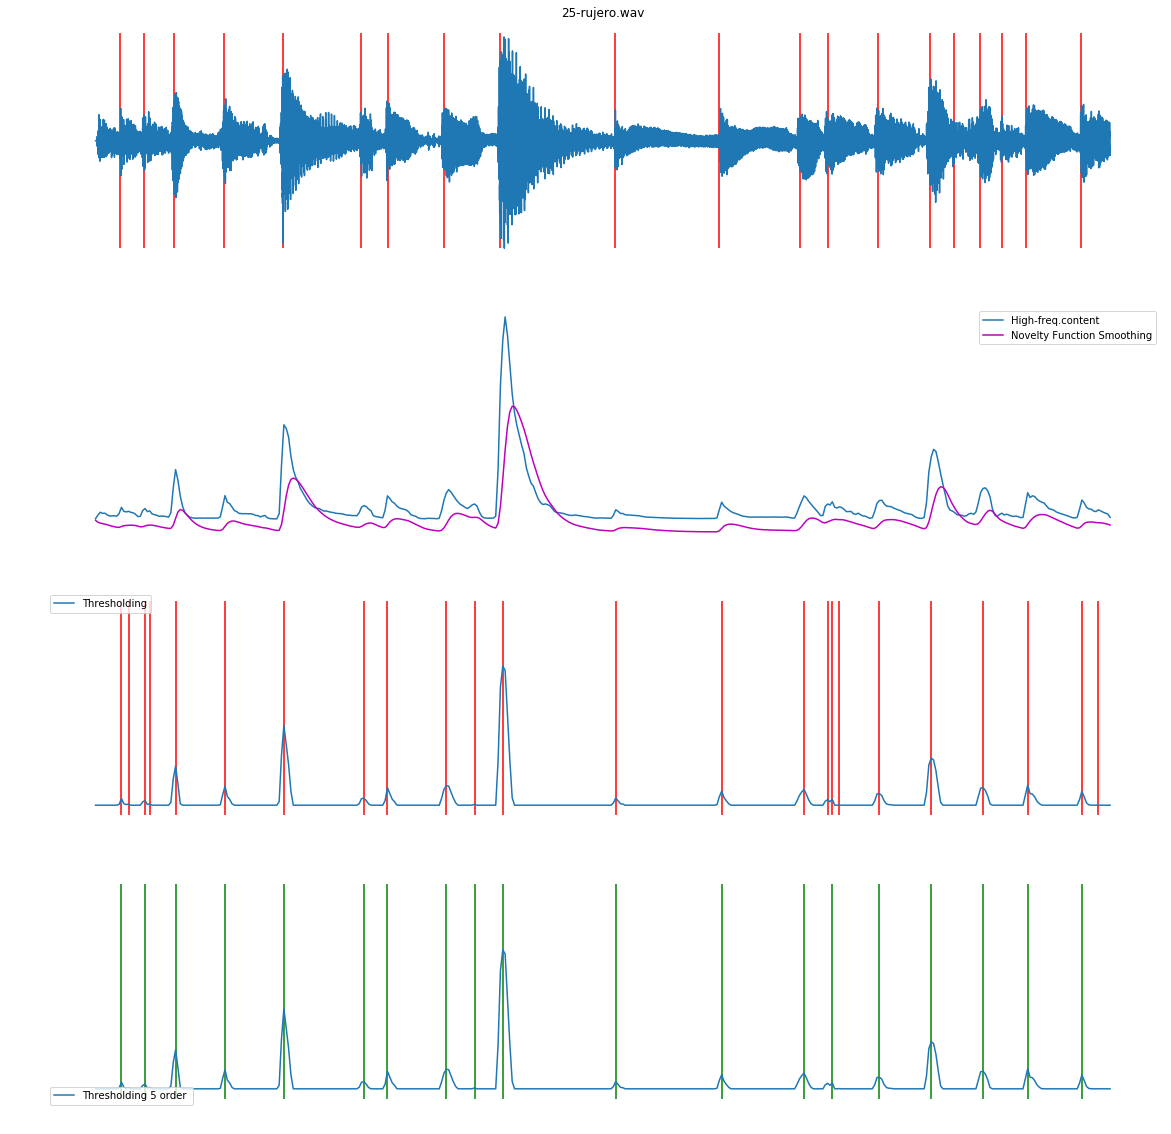

In [6]:
#Plotting HFC Onset Detection
    
f, axarr = plt.subplots(4,1,figsize=(20, 20))
axarr[0].plot(t,x);axarr[0].set_title(file);axarr[0].axis('off')
axarr[0].vlines(onsets, -1, 1, color='r');axarr[0].axis('off')

axarr[1].plot(hfc,label='High-freq.content');axarr[1].axis('off');axarr[1].legend(loc=1)
axarr[1].plot(nov,label='Novelty Function Smoothing',color='m');axarr[1].axis('off');axarr[1].legend(loc=1)

axarr[2].vlines(onsets_hfc, -0.1, 2, color='r');axarr[2].axis('off')
axarr[2].plot(thr, label='Thresholding');axarr[2].axis('off');axarr[2].legend(loc=2)

axarr[3].vlines(onsets_thr_hfc, -0.1, 2, color='g');axarr[3].axis('off')
axarr[3].plot(thr, label='Thresholding 5 order ');axarr[2].axis('off');axarr[3].legend(loc=3)




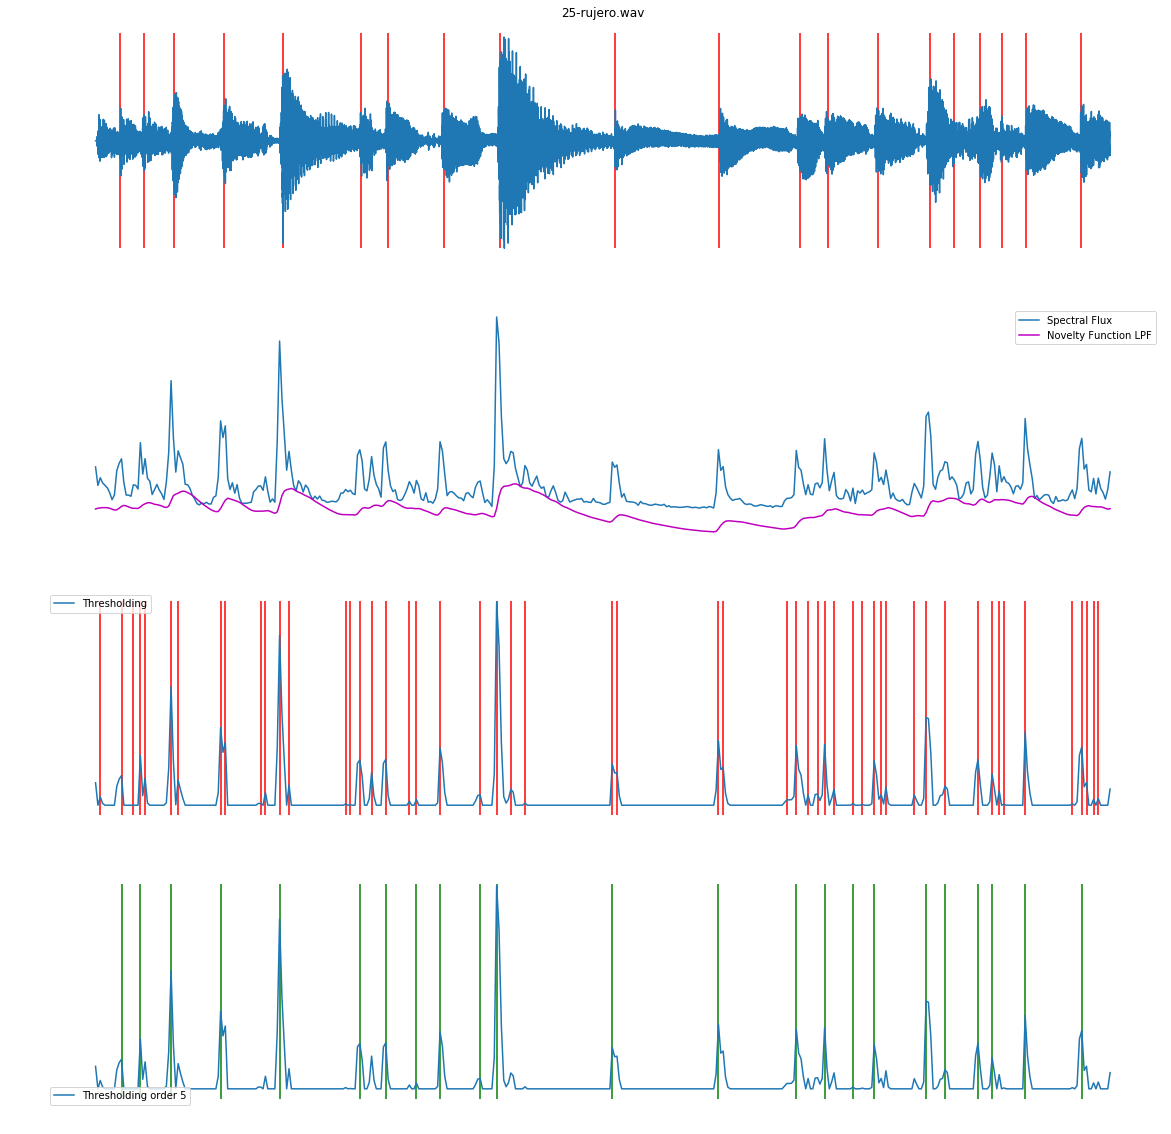

In [7]:
    #Plotting Spectral Flux Onset Detection

f, axarr = plt.subplots(4,1,figsize=(20, 20))
axarr[0].plot(t,x);axarr[0].set_title(file);axarr[0].axis('off')
axarr[0].vlines(onsets, -1, 1, color='r');axarr[0].axis('off')

axarr[1].plot(SF,label='Spectral Flux');axarr[1].axis('off');axarr[1].legend(loc=1)
axarr[1].plot(nov_SF,label='Novelty Function LPF',color='m');axarr[1].axis('off');axarr[1].legend(loc=1)

axarr[2].vlines(onsets_SF, -0.1, 2, color='r');axarr[2].axis('off')
axarr[2].plot(thr_SF, label='Thresholding');axarr[2].axis('off');axarr[2].legend(loc=2)

axarr[3].vlines(onsets_thr_SF, -0.1, 2, color='g');axarr[3].axis('off')
axarr[3].plot(thr_SF, label='Thresholding order 5');axarr[2].axis('off');axarr[3].legend(loc=3)


Taking into account that we are using an easy methodology including simple signal processing steps, we get pretty good results. Obviously, these results can be better by improving the thresholding, mainly in signals with high dynamics. In this case, a fixed threshold will tend to miss onsets in the quietest sections and also will detect false onsets in the loudest ones. Because of this, some adaptation of the threshold is required. 

In our case we are using a linear smoothing filter that corresponds to a low pass filtering. The results can be improved including some nonlinear filters or methods based on percentiles, for instance, the local median function.

Talking about the novelty functions and which is the most suitable for each type of signals we conclude the following: we get better results if we use a method based on the high frecuency content to track onsets in a more percussive signal. On the other hand, if we have to detect onsets in a signal that is stable in terms of loudness, but if contains frequency variations predominating, maybe it is better to use methods based on spectral features.